In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from stripes.detection import Detector
%matplotlib inline

Чтение файлов с диска:

In [2]:
def read_images(path):
    images_names = glob.glob(path + '/' + '*.jpg')
    return [cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB) for image_name in images_names]

images = read_images("../images/tables")
print len(images)

15


Размер итогового изображения с таблицей:

In [3]:
w_target, h_target = 148 * 5, 166 * 5
print "{} x {}" .format(w_target, h_target)

740 x 830


Предобработка (размеры ядер и параметры фильтров пока хардкод под картинки 1280х960)

In [4]:
def denoise(image, ksize=15):
    return cv2.medianBlur(image, ksize=ksize)


def binarize(image, blocksize=11, C=0):
    if len(image.shape) == 2:
        out = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, blockSize=blocksize, C=C)
    else:
        out = cv2.adaptiveThreshold(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                       cv2.THRESH_BINARY, blockSize=blocksize, C=C)
    return out


def morphology_open(image, ksize=3):
    kernel = np.ones(ksize)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

Работа с контурами:

In [27]:
def get_max_area_contour_id(contours):
    max_area = 0.
    max_contour_id = -1
    for j, contour in enumerate(contours):
        new_area = cv2.contourArea(contour)
        if new_area >= max_area:
            max_area = new_area
            max_contour_id = j
    return max_contour_id


def approximate_contour(contour, eps=0.01):
    return cv2.approxPolyDP(contour, epsilon=eps*cv2.arcLength(contour, closed=True), closed=True)


def get_correct_arrangement(rect):
    """
    Find arrangment indices as follows
    # 0 -> 1
    # |    |
    # 3 <- 2
    """
    arrangement = [-1] * 4
    x1i, x2i, x3i, x4i = np.argsort(rect[:, 0])
    
    if rect[x1i, 1] > rect[x2i, 1]:
        arrangement[0] = x2i
        arrangement[3] = x1i
    else:
        arrangement[0] = x1i
        arrangement[3] = x2i

    if rect[x3i, 1] > rect[x4i, 1]:
        arrangement[1] = x4i
        arrangement[2] = x3i
    else:
        arrangement[2] = x4i
        arrangement[1] = x3i

    return arrangement

Преобразование изображения:

In [18]:
def get_warp_matrix(src_rect, dist_rect):
    h, status = cv2.findHomography(src_rect, dist_rect)
    return h


def warp(image, warp_matrix, dist_shape=(w_target, h_target)):
    return cv2.warpPerspective(image, warp_matrix, (w_target, h_target))

In [40]:
def run(image):
    
    # Предобработка
    image_denoised = denoise(image)
    image_binary = binarize(image_denoised)
    image_morph = morphology_open(image_binary)
    
    # Контуры
    r, contours, h = cv2.findContours(image_morph, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxId = get_max_area_contour_id(contours)
    contour = contours[maxId]
    
    poly = approximate_contour(contour)
    if len(poly) != 4:
        print "Failed to approx with 4 points"
        return None
    image_contoured = image.copy()
    cv2.drawContours(image_contoured, [poly], 0, (255, 0, 0), 5)
    
    # Трансформация
    correct_arrangement = get_correct_arrangement(np.squeeze(poly, 1))
    src_rect = np.squeeze(poly, 1)[correct_arrangement]
    
    dist_rect = np.array([[[0, 0]],
                          [[w_target, 0]],
                          [[w_target, h_target]],
                          [[0, h_target]]])

    warp_matrix = get_warp_matrix(src_rect, dist_rect)
    image_warped = warp(image, warp_matrix)
    
    
    # Отрисовка
    plt.figure(figsize=(15, 35))
    plt.subplot(1, 3, 1)
    plt.title("Source image")
    plt.imshow(image)
    plt.subplot(1, 3, 2)
    plt.title("Contoured image")
    plt.imshow(image_contoured)
    plt.subplot(1, 3, 3)
    plt.title("Cropped image")
    plt.imshow(image_warped)
    plt.show()

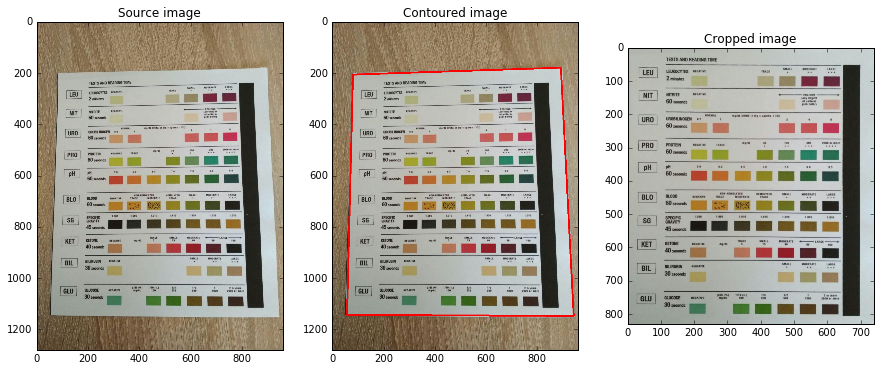

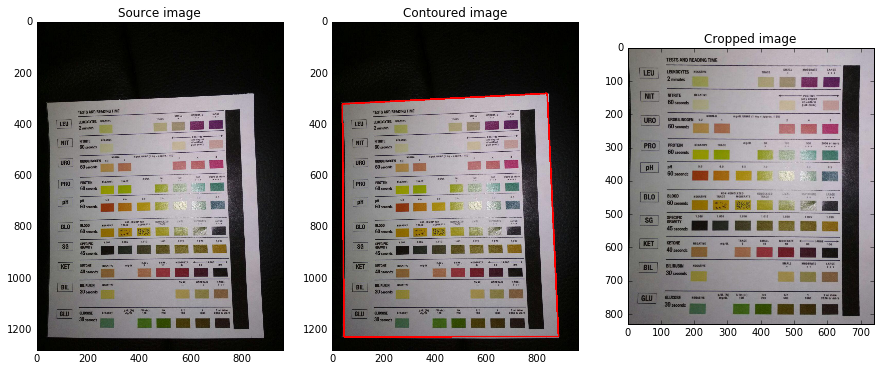

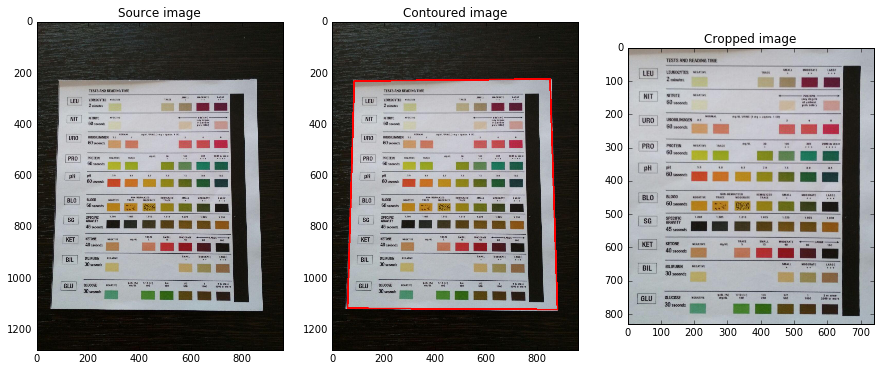

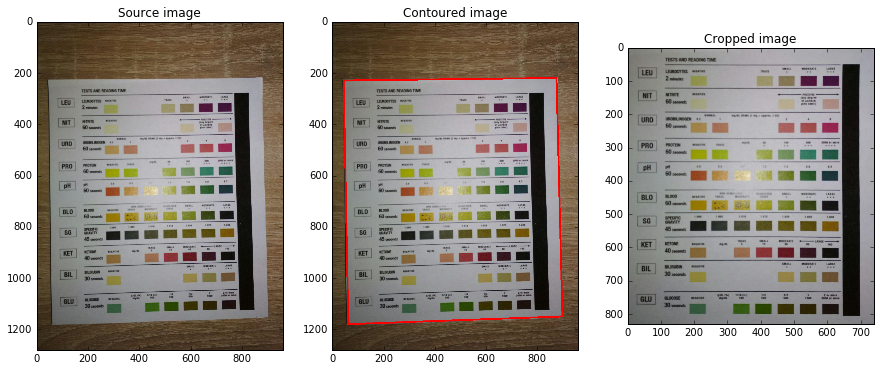

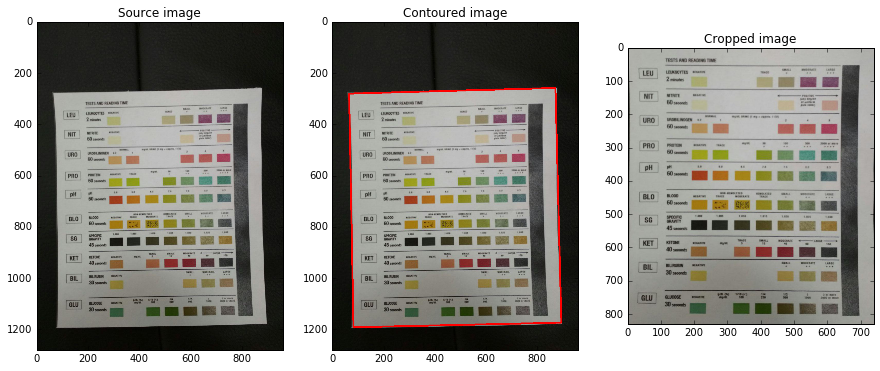

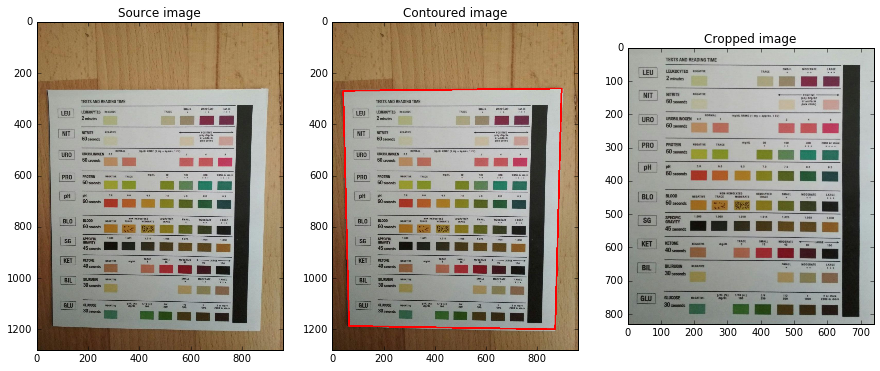

Failed to approx with 4 points


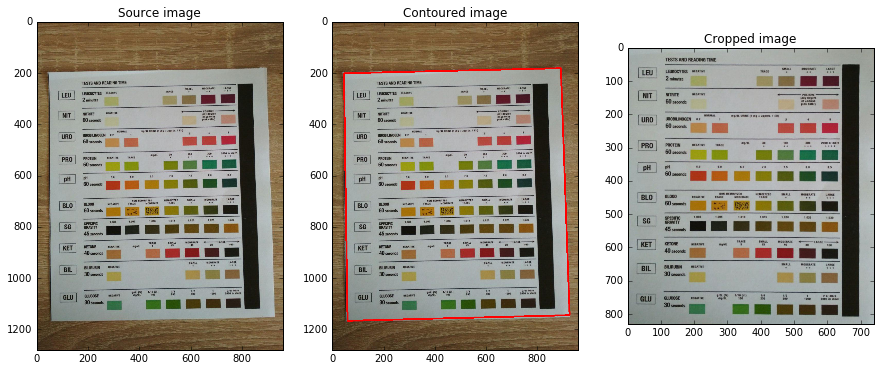

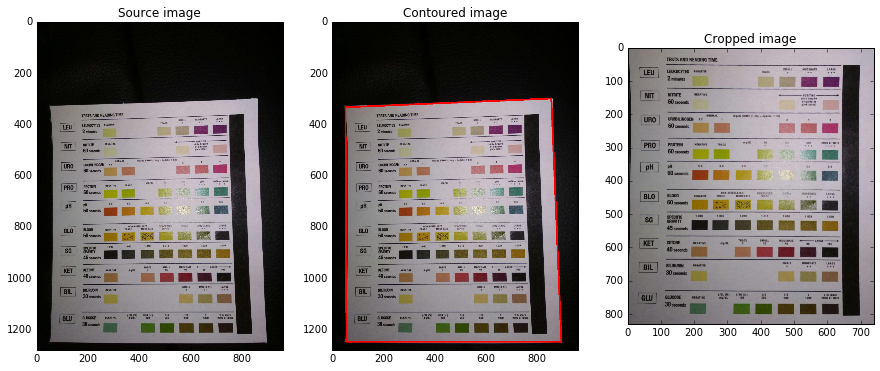

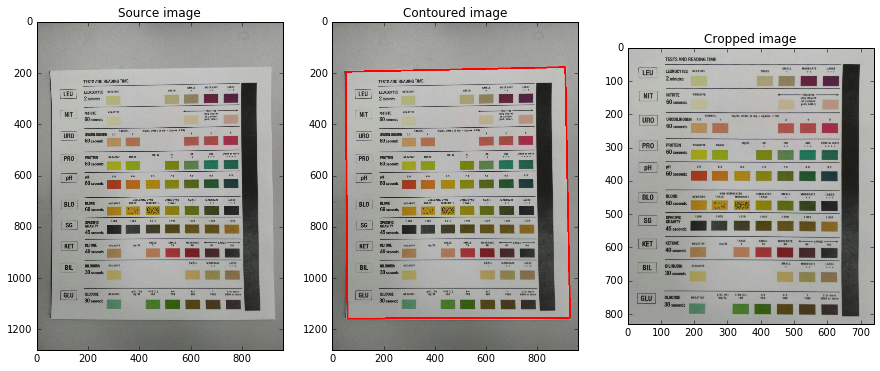

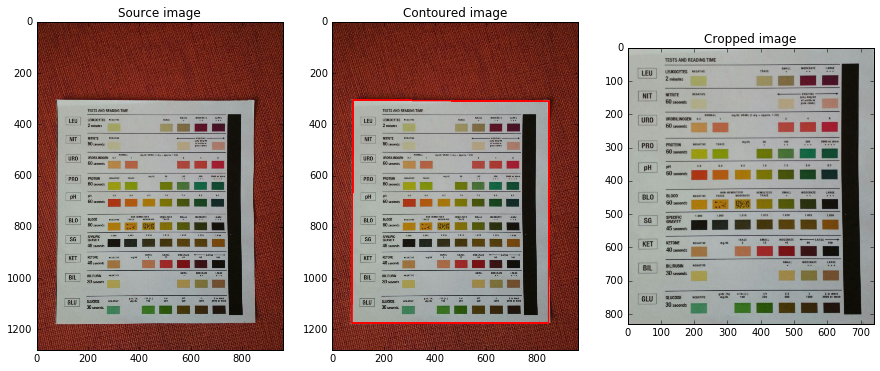

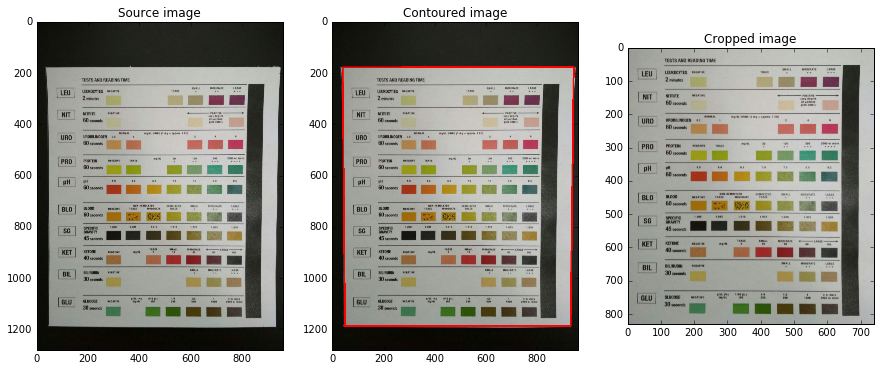

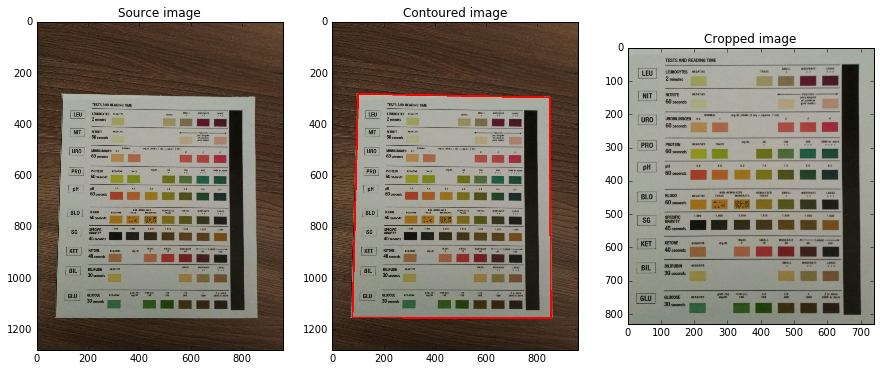

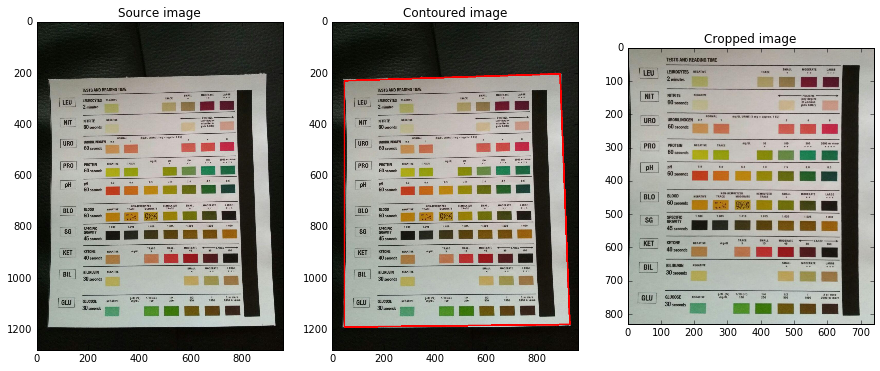

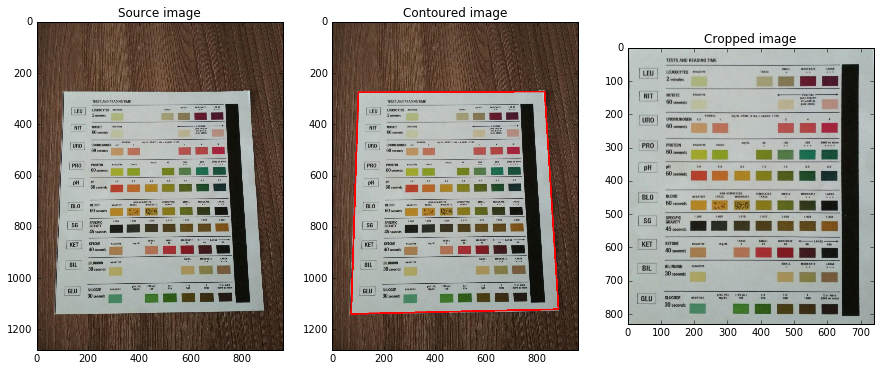

In [41]:
for image in images:
    run(image)